In [3]:

import os
import cv2
import numpy as np
import time
from matplotlib import pyplot as plt

In [4]:
from pbputils import driver

In [5]:
def show_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')  
    plt.show()

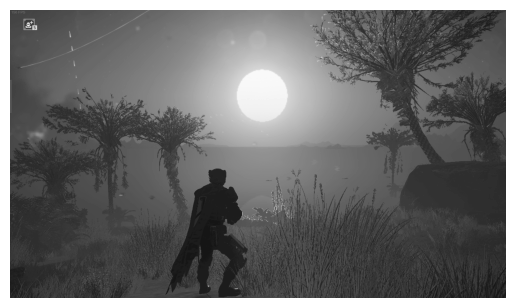

(1486, 2559)


In [13]:
img=cv2.imread('myimages/HD2_original.png',cv2.IMREAD_GRAYSCALE)

show_image(img)

print(img.shape)

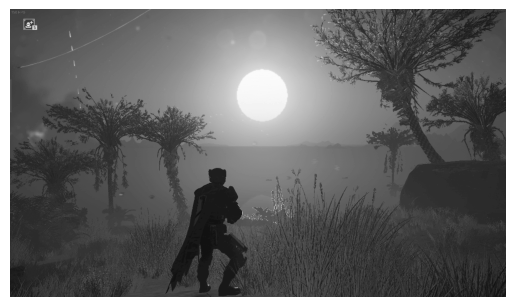

(580, 1000)


In [ ]:
def resize_img(img_src, req_width=200): #preserved aspect ratio #200 for small images, 1000 for bigger images such as Screenshots
    img = img_src.copy()
    if isinstance(img, str):
        img = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
    
    h, w = img.shape
    req_h = int(1.0 * req_width * h / w)

    img = cv2.resize(img, (req_width, req_h))

    return img


resized_img=resize_img(img)

show_image(resized_img)

print(resized_img.shape)

In [8]:


def image_gaussian(source_img, kernel=(1, 1)):
    img = source_img.copy()
    norm_img = np.zeros((img.shape[0], img.shape[1]))
    if np.max(img) > 1.0:
        img = cv2.normalize(img, norm_img, 0, 255, cv2.NORM_MINMAX)

    img = cv2.GaussianBlur(img, kernel, 0)
    img = (img * 255).astype(np.uint8)

    return img

In [9]:
def compute_edge(img_grey,p:np.int8,n,m,x_step=1,y_step=1,transpose=False): #function that computes a mask to get the edges
    '''
    p is the degree thresolds
    n,m are the patch sizes consider

    _step are the steps size

    transpose is a flag to check if we compute on the transpose of the patch as well
    '''
    mask = np.full(img_grey.shape, 0, np.uint8)
    h, w = img_grey.shape[:2]

    max_i = h - n + 1
    max_j=w-m+1
    for i in range(0, max_i, y_step):
        for j in range(0, max_j, x_step):
            i_n = i + n
            j_m = j + m

            patch = img_grey[i:i_n, j:j_m]
            if not patch.any():
                continue
            terms,deg=driver(patch)
            if deg>=p:
                mask[i,j]=255 #set to white
            elif transpose:
                termsT,degT=driver(patch.T)
                #print(deg,degT)
                if degT>=p:
                    mask[i,j]=255

            
            j += x_step + j_m
        i += y_step + i_n

    return mask


In [ ]:
def bigdriver(image_path,**kwargs):
    '''
    Driver function for the images. driver was already used for the Pbp
    '''
    div=70 #thresolding param
    assert os.path.exists(image_path), 'Image doesnt exists'
    img=cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    print('Original Image')
    show_image(img)

    #pre-processing step
    img_resized=resize_img(img)
    start=time.perf_counter()
    img_gauss_resized=image_gaussian(img_resized,(3,3))
    img_gauss_resized = img_gauss_resized // div * div + div // 2 #color thresolding

    #saves a copy after the pre-processing
    img_after_process=img_gauss_resized.copy()
    print('after pre processing')
    show_image(img_after_process)
    process_savepath= image_path.replace("_original", "_process")
    print(process_savepath)
    plt.imsave(process_savepath,img_after_process,cmap='gray')



    #computes and saves the mask
    mask=compute_edge(img_grey=img_after_process,p=kwargs.get('p'),n=kwargs.get('n'),m=kwargs.get('m'),x_step=kwargs.get('x_step'),y_step=kwargs.get('y_step'),transpose=True)
    print('proposed output')
    show_image(mask)
    last=time.perf_counter()-start
    mask_savepath= image_path.replace("_original", "output")
    plt.imsave(mask_savepath,mask,cmap='gray')
    print('time taken',last)

    

Original Image


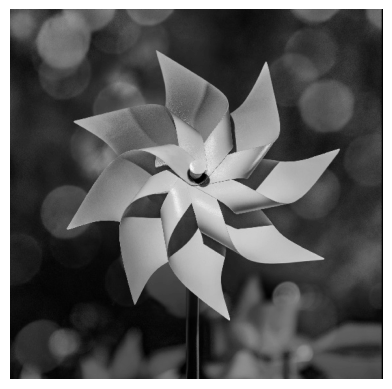

after pre processing


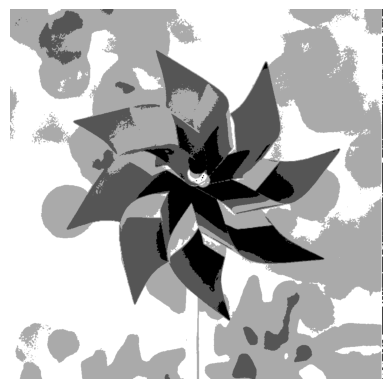

myimages/flower_process.png


KeyboardInterrupt: 

In [ ]:
kwargs =  {
        "n": 3, # the height of the patch
        "m": 3, # the width of the patch
        "x_step": 1, 
        "y_step": 1, 
        "p": 2, # degree threshold 
        "image_path": "myimages/flower_original.png", # image path, to modify, add _original after the image name.
    }

bigdriver(**kwargs)